In [249]:
import warnings
warnings.filterwarnings('ignore')

In [197]:
import numpy as np
import pandas as pd

In [198]:
import math
import random
import re
from collections import Counter

In [199]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi'] = 100

### Constructing typical English incidence matrix
• Entries are probabilities with which two letters typically follow each other  
• Bigram frequencies used are from http://practicalcryptography.com/media/cryptanalysis/files/english_bigrams_1.txt

In [200]:
bigram_frequencies = pd.read_csv('english_bigrams.txt', sep=' ', header=None)
bigram_frequencies.columns = ['bigram', 'frequency']
bigram_frequencies['first'] = bigram_frequencies.bigram.str[0]
bigram_frequencies['second'] = bigram_frequencies.bigram.str[1]
bigram_frequencies['probability'] = bigram_frequencies.frequency/bigram_frequencies.frequency.sum()
bigram_frequencies.head()

,bigram,frequency,first,second,probability
0,TH,116997844,T,H,0.027057
1,HE,100689263,H,E,0.023285
2,IN,87674002,I,N,0.020276
3,ER,77134382,E,R,0.017838
4,AN,69775179,A,N,0.016136


In [201]:
bigram_frequencies_sorted = bigram_frequencies.sort_values('bigram') 
bigram_frequencies_sorted_freq = bigram_frequencies_sorted[['first', 'second', 'frequency']]
bigram_frequencies_sorted_prob = bigram_frequencies_sorted[['first', 'second', 'probability']]
bigram_frequencies_sorted_freq.head()

,first,second,frequency
323,A,A,1721143
141,A,B,8775582
71,A,C,17904683
89,A,D,14877234
383,A,E,815963


In [202]:
# probabilities 
typical_incidence_matrix_prob = bigram_frequencies_sorted_prob.set_index(['first', 'second']).unstack(0).T
typical_incidence_matrix_prob = typical_incidence_matrix_prob.iloc[1:] # del first row
typical_incidence_matrix_prob.drop(typical_incidence_matrix_prob.columns[0], axis=1, inplace=True) # del first col
#print(typical_incidence_matrix_prob.shape) # 26-by-26
#typical_incidence_matrix_prob.head()

In [214]:
# frequencies
typical_incidence_matrix_freq = bigram_frequencies_sorted_freq.set_index(['first', 'second']).unstack(0).T
typical_incidence_matrix_freq = typical_incidence_matrix_freq.iloc[1:] # del first row
typical_incidence_matrix_freq.drop(typical_incidence_matrix_freq.columns[0], axis=1, inplace=True) # del first col
typical_incidence_matrix_freq.head()

second                    A          B           C           D           E  \
          first                                                              
frequency A       1721143.0  8775582.0  17904683.0  14877234.0    815963.0   
          B       8867461.0   689158.0    320380.0    141752.0  19468489.0   
          C      19930754.0   298053.0   3026492.0    358435.0  19803619.0   
          D      17584055.0  6106719.0   3782481.0   4001275.0  27029835.0   
          E      43329810.0  9738798.0  25775798.0  46647960.0  18497942.0   

second                    F          G           H           I          J  \
          first                                                             
frequency A       5702567.0  8809266.0   2225270.0  13974919.0   870262.0   
          B         75352.0    40516.0    154489.0   4356462.0   282608.0   
          C        267630.0   181590.0  20132750.0   8446084.0    41526.0   
          D       4033878.0  2442139.0   4585765.0  21673998.0   799366.0   
          E      13252227.0  8286463.0   7559141.0  16026915.0  1256993.0   

second           ...          Q           R           S           T  \
          first  ...                                                  
frequency A      ...   315068.0  42353262.0  37773878.0  48274564.0   
          B      ...     5513.0   4621080.0   1409672.0    428276.0   
          C      ...   157546.0   5514347.0   1381608.0  11888752.0   
          D      ...   283314.0   5701879.0  10429887.0  15759673.0   
          E      ...  1461436.0  77134382.0  57070453.0  32872552.0   

second                   U           V           W          X           Y  \
          first                                                             
frequency A      4884168.0   8288885.0   3918960.0   660826.0  11523416.0   
          B      8113271.0    120081.0    140189.0     3021.0   5232074.0   
          C      4604045.0     94224.0    257253.0     5300.0   1145316.0   
          D      5861311.0   1238565.0   4906814.0    27413.0   2218040.0   
          E      3674130.0  10574011.0  14776406.0  5649363.0   7528342.0   

second                  Z  
          first            
frequency A      768359.0  
          B        8132.0  
          C       57914.0  
          D       98038.0  
          E      465466.0  

[5 rows x 26 columns]

In [218]:
letters = list(map(chr, range(65, 91))) # uppercase alphabet
typical_incidence_matrix_freq_clean = pd.DataFrame(typical_incidence_matrix_freq.values, index=letters, columns=letters)
typical_incidence_matrix_freq_arr = typical_incidence_matrix_freq_clean.values
#print(typical_incidence_matrix_freq_arr)

typical_incidence_matrix_freq_clean.at['N', 'A'] = 23547524 # bug fix (cell was becoming NaN)

typical_incidence_matrix_freq_clean.to_csv('english_incidence_matrix.csv') 
typical_incidence_matrix_freq_clean.head() # official English frequency bigram incidence matrix

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
A,1721143.0,8775582.0,17904683.0,14877234.0,815963.0,5702567.0,8809266.0,2225270.0,13974919.0,870262.0,...,315068.0,42353262.0,37773878.0,48274564.0,4884168.0,8288885.0,3918960.0,660826.0,11523416.0,768359.0
B,8867461.0,689158.0,320380.0,141752.0,19468489.0,75352.0,40516.0,154489.0,4356462.0,282608.0,...,5513.0,4621080.0,1409672.0,428276.0,8113271.0,120081.0,140189.0,3021.0,5232074.0,8132.0
C,19930754.0,298053.0,3026492.0,358435.0,19803619.0,267630.0,181590.0,20132750.0,8446084.0,41526.0,...,157546.0,5514347.0,1381608.0,11888752.0,4604045.0,94224.0,257253.0,5300.0,1145316.0,57914.0
D,17584055.0,6106719.0,3782481.0,4001275.0,27029835.0,4033878.0,2442139.0,4585765.0,21673998.0,799366.0,...,283314.0,5701879.0,10429887.0,15759673.0,5861311.0,1238565.0,4906814.0,27413.0,2218040.0,98038.0
E,43329810.0,9738798.0,25775798.0,46647960.0,18497942.0,13252227.0,8286463.0,7559141.0,16026915.0,1256993.0,...,1461436.0,77134382.0,57070453.0,32872552.0,3674130.0,10574011.0,14776406.0,5649363.0,7528342.0,465466.0


### Constructing arbitrary incidence matrices

Creating an incidence matrix for a given text, with probability values

In [8]:
def create_template_matrix(text):
    index = sorted(list(set(text)))
    columns = index
    num_unique_letters = len(columns)
    data = np.zeros((num_unique_letters, num_unique_letters))
    template_matrix = pd.DataFrame(data, index=index, columns=columns)
    return template_matrix

# testing
#text = 'MATHEMATICS'
#print(create_template_matrix(text))

In [9]:
def get_bigrams(text):
    return re.findall(r'(?=([a-zA-Z]{2}))', text)

def get_bigram_frequencies(text):
    bigrams = get_bigrams(text)
    counts = Counter(bigrams)
    df_counts = pd.DataFrame.from_dict(counts, orient='index').reset_index()
    df_counts = df_counts.rename(columns={'index':'bigram', 0:'frequency'})
    df_counts['first'] = df_counts.bigram.str[0]
    df_counts['second'] = df_counts.bigram.str[1]
    df_counts = df_counts.sort_values('bigram') 
    return df_counts

def get_incidence_matrix(text):
    incidence_matrix = create_template_matrix(text)
    df_bigram_frequencies = get_bigram_frequencies(text)
    for index, row in df_bigram_frequencies.iterrows():
        first, second = row['first'], row['second']
        incidence_matrix.at[first, second] = row['frequency']
    incidence_matrix_probs = incidence_matrix.apply(lambda x: x / incidence_matrix.values.sum())
    incidence_matrix_probs_arr = incidence_matrix_probs.values
    return incidence_matrix_probs_arr

# testing
#text = 'MATHEMATICS'
#print(get_bigrams(text))
#print(get_bigram_frequencies(text))
#print(get_incidence_matrix(text))

Retrieving part of English incidency matrix, with frequency values

In [222]:
def get_subpart_english_incidence_matrix(text, typical_incidence_matrix): # typical_incidence_matrix = entire English bigram matrix
    subpart_matrix = create_template_matrix(text)
    for index, row in subpart_matrix.iterrows():
        for col in subpart_matrix.columns:
            #print(index, col, typical_incidence_matrix.at[index, col])
            subpart_matrix.at[index, col] = typical_incidence_matrix.at[index, col]
    subpart_matrix_probs = subpart_matrix.apply(lambda x: x / subpart_matrix.values.sum())
    subpart_matrix_probs_arr = subpart_matrix_probs.values
    return subpart_matrix_probs
    
# testing
#text = 'MATHEMATICS'
#print(get_subpart_english_incidence_matrix(text, typical_incidence_matrix_freq_clean))

### Measuring typical-ness of text
Getting Euclidean distance between text's incidence matrix and its associated subpart typical English incidence matrix

In [223]:
def get_dist_from_typical(text, english_bigram_matrix): # english_bigram_matrix is the entire English bigram matrix 
    text_incidence_matrix = get_incidence_matrix(text)
    #print(text_incidence_matrix)
    typical_subpart_incidence_matrix = get_subpart_english_incidence_matrix(text, english_bigram_matrix)
    #print(typical_subpart_incidence_matrix)
    dist = np.linalg.norm(text_incidence_matrix - typical_subpart_incidence_matrix)
    return dist

# testing
#text = 'CAB'
#english_bigram_matrix = typical_incidence_matrix_freq_clean
#print(get_dist_from_typical(text, english_bigram_matrix))

### Constructing encoding and decoding schemes
• Substitution ciphers are random permutations of English letters and spaces  
• Decoding involves repeatedly randomly switching two letters of encoded string, with the goal of minimizing distance from typical incidence matrix

In [12]:
def encode(text):
    return ''.join(random.sample(text, len(text))) # random permutation of text

def swap(s, i, j):
    lst = list(s)
    lst[i], lst[j] = lst[j], lst[i]
    return ''.join(lst)

def exchange(text):
    (i, j) = tuple(random.sample(set(range(len(text))), 2))
    #print((i,j))
    return swap(text, i, j) # exchanges two random characters in string

# testing
#text = 'THANKFUL'
#encoded_text = encode(text)
#exchanged_encoded_text = exchange(encoded_text)
#print(encoded_text)
#print(exchanged_encoded_text)

In [13]:
def decode(english_bigram_matrix, text, encoded_text, switch_prob): 
    cur_text = encoded_text
    cur_dist_from_typical = math.inf
    num_exchanges = 0
    
    while cur_text != text: # possible for loop to run many times for long texts
        exchanged_encoded_text = exchange(cur_text)
        #print('current text:', cur_text)
        #print('exchanged encoded text:', exchanged_encoded_text)
        exchanged_dist_from_typical = get_dist_from_typical(exchanged_encoded_text, english_bigram_matrix) # only text's letters involved
        if exchanged_dist_from_typical <= cur_dist_from_typical:
            cur_dist_from_typical = exchanged_dist_from_typical
            cur_text = exchanged_encoded_text
            num_exchanges += 1
        else:
            drawn_prob = random.random()
            #print('drawn probability:', drawn_prob)
            if drawn_prob <= switch_prob: 
                cur_dist_from_typical = exchanged_dist_from_typical 
                cur_text = exchanged_encoded_text 
            else:
                cur_dist_from_typical = get_dist_from_typical(cur_text, english_bigram_matrix)
                #print('no exchange')
        
        #print('distance from typical (projected):', exchanged_dist_from_typical)
        #print('distance from typical (actual):', cur_dist_from_typical)
        #print('# exchanges:', num_exchanges)
        
    return num_exchanges # returns the number of informed exchanges needed to resolve to original

In [15]:
# testing decoding
english_bigram_matrix = typical_incidence_matrix_freq_clean
text = 'BATS'
encoded_text = encode(text)
switch_prob = 0.5 # later, observe over multiple values

print('text:', text)
print('encoded text:', encoded_text)
print(decode(english_bigram_matrix, text, encoded_text, switch_prob), 'exchanges')

text: BATS
encoded text: STAB
13 exchanges


### Gathering heterograms
• Dataset obtained from https://figshare.com/articles/Data_and_tools_for_studying_isograms/5245810/1  
• First three columns are isogramy (order of isogram), word length, word text

In [229]:
isograms = pd.read_csv('bnc_isograms.csv', sep='\\t', engine='python', header=None)
isograms = isograms.iloc[:, 0:3]
isograms.columns = ['order', 'length', 'word']
isograms['order'] = isograms['order'].str[1:]
isograms['order'] = isograms['order'].astype(int)
isograms['length'] = isograms['length'].astype(int)

heterograms = isograms[isograms['order'] == 1]
heterograms = heterograms[heterograms['length'] > 1] # since exchanges involve two letters
heterograms['word'] = heterograms['word'].str.upper() 

print(heterograms.shape)
heterograms.head()

(110985, 3)


,order,length,word
0,1,2,AH
1,1,3,YES
2,1,3,SHE
4,1,4,ABER
5,1,5,ABOUT


In [232]:
heterograms_counts = heterograms['length'].value_counts().to_dict()
heterograms_counts_df = pd.DataFrame(heterograms_counts, index=['frequency']).transpose()
heterograms_counts_df.reset_index(inplace=True)
heterograms_counts_df.columns = ['length', 'frequency']
heterograms_counts_df = heterograms_counts_df.sort_values(by=['length'])

print(heterograms_counts_df.shape)
heterograms_counts_df.head(heterograms['length'].max())

(14, 2)


,length,frequency
8,2,1936
5,3,8441
3,4,14334
1,5,20621
0,6,22682
2,7,18882
4,8,12762
6,9,6880
7,10,2972
9,11,1057


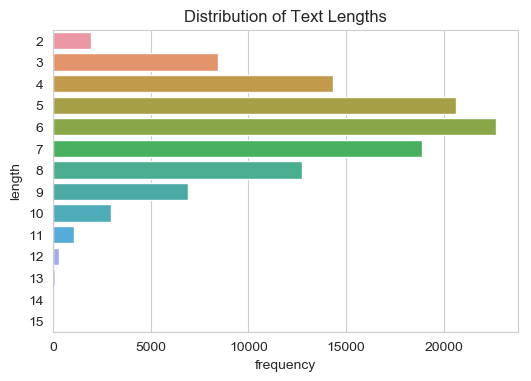

In [231]:
sns.set_style('whitegrid')  
histogram = sns.countplot(y='length', data=heterograms)
histogram.set(xlabel='frequency')
histogram.set(ylabel='length')
plt.title('Distribution of Text Lengths')
plt.show()

### Running decode algorithm on heterograms

In [238]:
for i in range(heterograms['length'].min(), heterograms['length'].max()):
    frames = {i:dat for i, dat in heterograms.groupby('length')}
    #frames = {i:dat.head(10) for i, dat in heterograms.groupby('length')} # small version

# testing
#frames[2].head()

In [257]:
def run_decode(length_df, switch_prob, english_bigram_matrix):
    length_df['prob'] = switch_prob
    length_df['exchanges'] = length_df['word'].map(lambda text: decode(english_bigram_matrix, text, encode(text), switch_prob))
    #length_df.to_csv('length_{}_{}.csv'.format(length_df.copy()['length'].iloc[0], switch_prob), index=False)
    return length_df

# testing
english_bigram_matrix = typical_incidence_matrix_freq_clean
switch_prob = 0.5 # later, observe over multiple values
output = run_decode(frames[3].head(10), switch_prob, english_bigram_matrix)
print(output)

    order  length word  prob  exchanges
1       1       3  YES   0.5          3
2       1       3  SHE   0.5          3
11      1       3  AHD   0.5          6
13      1       3  AIR   0.5          1
14      1       3  ALF   0.5          2
20      1       3  AND   0.5          4
26      1       3  ANG   0.5          0
31      1       3  ARD   0.5          2
33      1       3  ARD   0.5          6
37      1       3  ARE   0.5          1


In [ ]:
# main

switch_probs = [0.25, 0.5, 0.75, 1]
english_bigram_matrix = typical_incidence_matrix_freq_clean

combined_switch_probs_df = []
for switch_prob in switch_probs:
    combined_exchanges_df = []
    for i in len(frames.keys()):
        length_df = frames[i]
        exchanges_df = run_decode(length_df, switch_prob, english_bigram_matrix)
        combined_exchanges_df.append(exchanges_df)
    combined_exchanges_df = pd.concat(combined_exchanges_df)
    combined_exchanges_df.to_csv('combined_exchanges_{}.csv'.format(switch_prob), index=False)
    combined_switch_probs_df.append(combined_exchanges_df)
    combined_switch_probs_df.to_csv('results.csv', index=False)